# How to create a deep learning classifier to detect people with no mask for COVID-19 in a crowd of people

![](sample_images/cover.png)

## About the author: 

[Merishna S](https://www.linkedin.com/in/merishna-ss/) is an Artificial intelligence & Machine Learning engineer with strong fundamentals in machine learning algorithms (neural networks, dimensionality reduction, feature utilization, and extraction and clustering), programming, statistics, and mathematics. 

## Introduction

The [CDC](https://www.cdc.gov/) continues to monitor the spread of COVID-19 and advises people who are completely vaccinated as well as those who are not fully vaccinated to wear face masks. When visiting the doctor's office, hospitals, or long-term care institutions, the CDC recommends wearing masks and keeping a safe distance. 

Manually monitoring people entering such institutions is tedious and requires workforce. In this tutorial, we will learn how we can automate this process through deep learning techniques which will automatically detect people not wearing masks to prevent their entry.

## Glossary

**Deep Learning:** It is a kind of machine learning technique that enables learning through the use of neural networks that mimic the human brain.

## Prerequisites

1. Programming knowledge in Python.
2. Basic knowledge of Jupyter Notebook, Deep Learning, Keras.

## Creating the mask detection deep learning model

We will now look into building a Deep Learning model to predict (detect) if a person is violating the rules by not wearing a mask in public spaces.

### Step 1: Importing the necessary Python libraries

In [7]:
import numpy as np  # linear algebra
import cv2 # opencv
import matplotlib.pyplot as plt # image plotting
# keras
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

### Step 2: Getting the data

For the training data, we are using the face mask detection data from [here](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset). The dataset contains 12 thousand images divided into Test, Train, and Validation sets which were scraped from Google and the CelebFace dataset created by [Jessica Li ](https://www.kaggle.com/jessicali9530). To start using it, you can download the dataset and save it in the working directory.

In [141]:
# Load train and test set
train_dir = "data/Face Mask Dataset/Train"
test_dir = "data/Face Mask Dataset/Test"
val_dir = "data/Face Mask Dataset/Validation"

### Step 3: Reading a sample image and performing face detection

We will now read in a sample image from a busy airport and perform face detection using haar cascade classifier. The [Haar cascade classifier](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html), originally known as the Viola-Jones Face Detection Technique is a object detection algorithm for detecting faces in images or real-time video. 

Viola and Jones proposed edge or line detection features in their research paper "Rapid Object Detection using a Boosted Cascade of Simple Features," published in 2001. The algorithm is given a large number of positive photos with faces and a large number of negative images with no faces. The model developed as a result of this training can be found in the OpenCV GitHub [repository](https://github.com/opencv/opencv/tree/master/data/haarcascades).

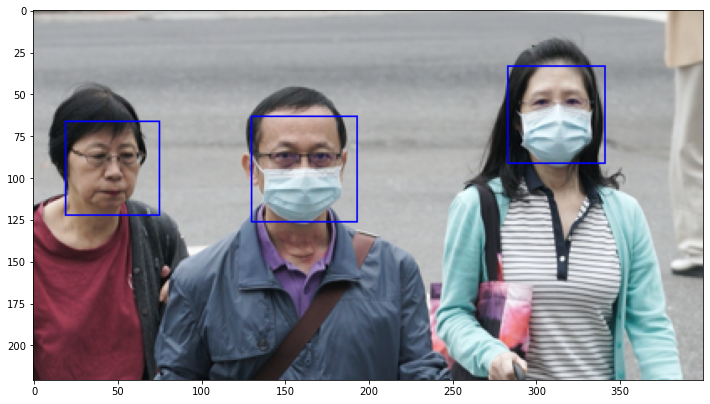

In [139]:
# Read a sample image
img = cv2.imread("sample_images/image (1).png")

# Keep a copy of coloured image
orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# Convert image to grayscale
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# loading haarcascade_frontalface_default.xml
face_detection_model = cv2.CascadeClassifier("data/haarcascade_frontalface_default.xml")

# detect faces in the given image
return_faces = face_detection_model.detectMultiScale(
    img, scaleFactor=1.07, minNeighbors=4
)  # returns a list of (x,y,w,h) tuples

# plotting the returned values
for (x, y, w, h) in return_faces:
    cv2.rectangle(orig_img, (x, y), (x + w, y + h), (0, 0, 255), 1)

plt.figure(figsize=(12, 12))
plt.imshow(orig_img)  # display the image

### Step 4: Data preprocessing for building the mask detection Keras model

We will now pass our datasets into Keras [ImageDataGenerator()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to perform some preliminary data augmentation steps such as rescaling. 

In [155]:
# Data preprocessing
# Train data
datagenerator = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2
)
train_generator = datagenerator.flow_from_directory(
    directory=train_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Validation data
val_datagenerator = ImageDataGenerator(rescale=1.0 / 255)
val_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Test data
test_datagenerator = ImageDataGenerator(rescale=1.0 / 255)
test_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Step 5: Create the mask detection transfer learning model using Keras

We are building the deep learning classifer using the VGG19 transfer learning model. The VGG19 model is the successor of AlexNet, a variation of the VGG model named after the group named as Visual Geometry Group at Oxford which created it. It is a deep CNN consisting of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer) used to classify images. 

It has been trained on [ImageNet](https://image-net.org/), a picture database with 14,197,122 images structured according to the WordNet hierarchy.

In [143]:
# Initializing the VGG19 model
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

# Initialize a sequential model
model = Sequential()
model.add(vgg19_model)
model.add(Flatten())
model.add(Dense(2, activation="sigmoid"))
model.summary()

# Compiling the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


### Step 6: Train the model

We will now train our neural network model for 20 epochs.

In [157]:
# Fit the model on train data along with validation data
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator) // 32,
)

C:\Users\Dell\AppData\Local\Temp\ipykernel_13456\3794504934.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/20
9/9 [==============================] - 32s 3s/step - loss: 0.6108 - accuracy: 0.6736
Epoch 2/20
9/9 [==============================] - 31s 3s/step - loss: 0.2472 - accuracy: 0.9028
Epoch 3/20
9/9 [==============================] - 31s 3s/step - loss: 0.1830 - accuracy: 0.9306
Epoch 4/20
9/9 [==============================] - 31s 3s/step - loss: 0.1312 - accuracy: 0.9549
Epoch 5/20
9/9 [==============================] - 29s 3s/step - loss: 0.1202 - accuracy: 0.9549
Epoch 6/20
9/9 [==============================] - 31s 3s/step - loss: 0.1185 - accuracy: 0.9653
Epoch 7/20
9/9 [==============================] - 33s 4s/step - loss: 0.1109 - accuracy: 0.9583
Epoch 8/20
9/9 [==============================] - 32s 3s/step - loss: 0.0954 - accuracy: 0.9722
Epoch 9/20
9/9 [==============================] - 34s 4s/step - loss: 0.0938 - accuracy: 0.9653
Epoch 10/20
9/9 [==============================] - 35s 4s/step - loss: 0.0752 - accuracy: 0.9757
Epoch 11/20
9/9 [======================

[0.05300654470920563, 0.9837499856948853]

### Step 7: Evaluate the model performance on test set

In [158]:
# Evaluate model performance on test data
model_loss, model_acc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

25/25 [==============================] - 78s 3s/step - loss: 0.0544 - accuracy: 0.9825
Model has a loss of 0.05 and accuracy 98.25%


### Step 8: Save the model

We can also choose to save the trained model as a h5 file for future use.

In [15]:
model.save('data/saved_model.h5')

## Step 7: Test the model on the sample image

We will now test the trained model on our use case for detecting faces and masks for a group of people. We take the detected face crops of the faces detected in the image and then predict the mask or no mask using the model trained.

1/1 [==============================] - 0s 142ms/step


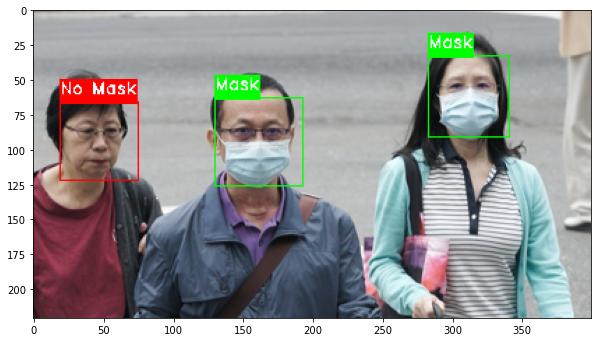

In [161]:
# label for mask detection
mask_det_label = {0: "Mask", 1: "No Mask"}
mask_det_label_colour = {0: (0, 255, 0), 1: (255, 0, 0)}
pad_y = 1  # padding for result text

main_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# For detected faces in the image
for i in range(len(return_faces)):
    (x, y, w, h) = return_faces[i]
    cropped_face = main_img[y : y + h, x : x + w]
    cropped_face = cv2.resize(cropped_face, (128, 128))
    cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
    mask_result = model.predict(cropped_face)  # make model prediction
    print_label = mask_det_label[mask_result.argmax()] # get mask/no mask based on prediction
    label_colour = mask_det_label_colour[mask_result.argmax()] # green for mask, red for no mask

    # Print result
    (t_w, t_h), _ = cv2.getTextSize(
        print_label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1
    )  # getting the text size
    
    cv2.rectangle(
        main_img,
        (x, y + pad_y),
        (x + t_w, y - t_h - pad_y - 6),
        label_colour,
        -1,
    )  # draw rectangle

    cv2.putText(
        main_img,
        print_label,
        (x, y - 6),
        cv2.FONT_HERSHEY_DUPLEX,
        0.4,
        (255, 255, 255), # white
        1,
    )  # print text

    cv2.rectangle(
        main_img,
        (x, y),
        (x + w, y + h),
        label_colour,
        1,
    )  # draw bounding box on face

plt.figure(figsize=(10, 10))
plt.imshow(main_img)  # display image

We can see that the model is correctly detecting faces and classifying them as mask and no mask.

-- THANK YOU -- 